In [1]:
import spikeinterface.full as si

In [2]:
import spyglass.spikesorting as sgs

[2023-06-08 16:30:49,412][INFO]: Connecting kyu@lmf-db.cin.ucsf.edu:3306
[2023-06-08 16:30:49,462][INFO]: Connected kyu@lmf-db.cin.ucsf.edu:3306


helper functions

In [3]:
import json
import numpy as np

def get_recording(nwb_file_name, shank_id):
    recording_path = (sgs.SpikeSortingRecording & {"nwb_file_name":nwb_file_name,
                                                   "sort_group_id":shank_id}).fetch("recording_path")[0]
    recording = si.load_extractor(recording_path)
    if recording.get_num_segments()>1:
        recording = si.concatenate_recordings([recording])
    return recording

def get_sorting(nwb_file_name, shank_id):
    sorting_path = (sgs.SpikeSorting & {"nwb_file_name":nwb_file_name,
                                        "sort_group_id":shank_id}).fetch("sorting_path")[0]
    sorting = si.load_extractor(sorting_path)

    return sorting

def open_json(path):
    with open(path, 'r') as f:
        c = json.load(f)
    return c

def get_curation_labels(nwb_file_name, shank_id, path_to_sorting_curation_repo):
    curation_uri = (sgs.CurationFigurl & {"nwb_file_name": nwb_file_name,
                                          "sort_group_id":shank_id}).fetch("new_curation_uri")[0]
    local_path = curation_uri.replace('gh://LorenFrankLab/sorting-curations/main/', path_to_sorting_curation_repo)
    curation_labels = open_json(local_path)
    return curation_labels


def get_units_to_remove(curation_labels):
    exclude_labels = ['noise', 'reject', 'mua']
    units_to_remove = []
    for unit_id, labels in curation_labels['labelsByUnit'].items():
        if np.sum([i in exclude_labels for i in labels])>0:
            units_to_remove.append(int(unit_id))
    return units_to_remove

def curate_sorting(sorting, curation_labels, skip_merge=True):
    if curation_labels['labelsByUnit']:
        units_to_remove = get_units_to_remove(curation_labels)
        sorting = sorting.remove_units(units_to_remove)
    if curation_labels['mergeGroups'] and skip_merge==False:
        sorting = si.MergeUnitsSorting(parent_sorting=sorting,
                                       units_to_merge=curation_labels['mergeGroups'],
                                      )
    return sorting

Define NWB file names

In [4]:
nwb_file_name1 = "L520230510_.nwb"
nwb_file_name2 = "L520230511_.nwb"

shank_id = 1

Load recording

In [5]:
recording1 = get_recording(nwb_file_name1, shank_id)
recording2 = get_recording(nwb_file_name2, shank_id)

Load sorting

In [6]:
sorting1 = get_sorting(nwb_file_name1, shank_id)
sorting2 = get_sorting(nwb_file_name2, shank_id)

get manual curation labels

In [19]:
# change this to path on your system
!cd ~/repos/sorting-curations && git pull origin main
path_to_sorting_curation_repo = '/home/kyu/repos/sorting-curations/'

From https://github.com/LorenFrankLab/sorting-curations
 * branch            main       -> FETCH_HEAD
Already up to date.


In [8]:
curation_labels1 = get_curation_labels(nwb_file_name1, shank_id, path_to_sorting_curation_repo)
curation_labels2 = get_curation_labels(nwb_file_name2, shank_id, path_to_sorting_curation_repo)

apply curation

In [9]:
sorting1 = curate_sorting(sorting1, curation_labels1)
sorting2 = curate_sorting(sorting2, curation_labels2)

extract waveforms

In [10]:
waveform_extractor1 = si.extract_waveforms(recording1, sorting1, folder="/tmp/we1",
                                           ms_before=1.0, ms_after=1.0,
                                           max_spikes_per_unit=5000,
                                           overwrite=True,
                                           seed=47,
                                           dtype=np.float32
                                          )

extract waveforms memmap:   0%|          | 0/1218 [00:00<?, ?it/s]

In [11]:
waveform_extractor2 = si.extract_waveforms(recording2, sorting2, folder="/tmp/we2",
                                           ms_before=1.0, ms_after=1.0,
                                           max_spikes_per_unit=5000,
                                           overwrite=True,
                                           seed=47,
                                           dtype=np.float32
                                          )

extract waveforms memmap:   0%|          | 0/1223 [00:00<?, ?it/s]

Quantify match

In [12]:
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import IncrementalPCA

def _compute_contamination(pcs_target_unit, pcs_other_unit, n_neighbors: int):
    # get lengths
    n_spikes_target = pcs_target_unit.shape[0]
    n_spikes_other = pcs_other_unit.shape[0]

    # concatenate
    pcs_concat = np.concatenate((pcs_target_unit, pcs_other_unit), axis=0)
    label_concat = np.concatenate((np.zeros(n_spikes_target), np.ones(n_spikes_other)))

    # if n_neighbors is greater than the number of spikes in both clusters, set it to max possible
    if n_neighbors > len(label_concat):
        n_neighbors_adjusted = len(label_concat) - 1
    else:
        n_neighbors_adjusted = n_neighbors

    _, membership_ind = (
        NearestNeighbors(n_neighbors=n_neighbors_adjusted, algorithm="auto").fit(pcs_concat).kneighbors()
    )
    
    target_nn_in_other = np.sum(label_concat[membership_ind[:n_spikes_target]] == 1)

    # target_nn_in_target = np.sum(label_concat[membership_ind[:n_spikes_target]] == 0)
    # other_nn_in_other = np.sum(label_concat[membership_ind[n_spikes_target:]] == 1)

    contamination = target_nn_in_other / (n_spikes_target) / n_neighbors_adjusted

    return contamination

def compute_nn_distance(waveform_extractor1, waveform_extractor2, shank_id, seed=47, n_neighbors=5, n_spikes=1000, n_components=5):
    
    rng = np.random.default_rng(seed=seed)
    sparsity1 = si.compute_sparsity(waveform_extractor1, num_channels=3)
    sparsity2 = si.compute_sparsity(waveform_extractor2, num_channels=3)
    
    output = np.zeros((waveform_extractor1.sorting.get_num_units(),
                       waveform_extractor2.sorting.get_num_units()))
    for unit_id1 in waveform_extractor1.sorting.get_unit_ids():
        waveforms_unit1 = waveform_extractor1.get_waveforms(unit_id=unit_id1)

        for unit_id2 in waveform_extractor2.sorting.get_unit_ids():
            waveforms_unit2 = waveform_extractor2.get_waveforms(unit_id=unit_id2)
            
            n_spikes = np.min([waveforms_unit1.shape[0], waveforms_unit2.shape[0], n_spikes])
            
            channels_with_signal = np.concatenate((sparsity1.unit_id_to_channel_ids[unit_id1], sparsity2.unit_id_to_channel_ids[unit_id2]))
            channels_with_signal = np.unique(channels_with_signal)
            # print(channels_with_signal)
            
            waveforms_unit1_sparse = waveforms_unit1[:,:,channels_with_signal-1-32*shank_id]
            waveforms_unit2_sparse = waveforms_unit2[:,:,channels_with_signal-1-32*shank_id]

            spike_ind1 = rng.choice(waveforms_unit1_sparse.shape[0], size=n_spikes, replace=False)
            spike_ind2 = rng.choice(waveforms_unit2_sparse.shape[0], size=n_spikes, replace=False)

            waveforms_unit1_sparse = waveforms_unit1_sparse[spike_ind1]
            waveforms_unit2_sparse = waveforms_unit2_sparse[spike_ind2]

            waveforms_unit1_sparse = np.reshape(waveforms_unit1_sparse, (n_spikes,-1))
            waveforms_unit2_sparse = np.reshape(waveforms_unit2_sparse, (n_spikes,-1))

            # concatenate
            waveforms_concat = np.concatenate((waveforms_unit1_sparse, waveforms_unit2_sparse), axis=0)
            
            pca = IncrementalPCA(n_components=n_components)
            pca.partial_fit(waveforms_concat)
            projected_waveforms = pca.transform(waveforms_concat)
            
            k = _compute_contamination(projected_waveforms[:n_spikes], projected_waveforms[n_spikes:], n_neighbors)
            output[waveform_extractor1.sorting.get_unit_ids()==unit_id1,
                   waveform_extractor2.sorting.get_unit_ids()==unit_id2] = k
    return output

In [13]:
contamination = compute_nn_distance(waveform_extractor1, waveform_extractor2, shank_id, n_neighbors=5, n_spikes=1000, n_components=4)

In [14]:
import matplotlib.pyplot as plt

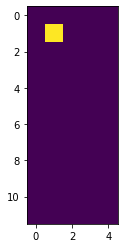

In [22]:
plt.imshow(contamination>0.3)

In [16]:
import sklearn.metrics.pairwise

def compute_cosine_similarity(waveform_extractor1, waveform_extractor2, shank_id):
    sparsity1 = si.compute_sparsity(waveform_extractor1, num_channels=3)
    sparsity2 = si.compute_sparsity(waveform_extractor2, num_channels=3)

    output = np.zeros((waveform_extractor1.sorting.get_num_units(),
                       waveform_extractor2.sorting.get_num_units()))
    for unit_id1 in waveform_extractor1.sorting.get_unit_ids():
        
        for unit_id2 in waveform_extractor2.sorting.get_unit_ids():
            
            channels_with_signal = np.concatenate((sparsity1.unit_id_to_channel_ids[unit_id1], sparsity2.unit_id_to_channel_ids[unit_id2]))
            channels_with_signal = np.unique(channels_with_signal)
            
            template_unit1 = waveform_extractor1.get_template(unit_id=unit_id1)
            template_unit1 = template_unit1[:,channels_with_signal-1-32*shank_id]
            template_unit1 = template_unit1.flatten()
            template_unit1 = np.expand_dims(template_unit1, axis=0)
            
            template_unit2 = waveform_extractor2.get_template(unit_id=unit_id2)
            template_unit2 = template_unit2[:,channels_with_signal-1-32*shank_id]
            template_unit2 = template_unit2.flatten()
            template_unit2 = np.expand_dims(template_unit2, axis=0)

            k = sklearn.metrics.pairwise.cosine_similarity(template_unit1, template_unit2)
            output[waveform_extractor1.sorting.get_unit_ids()==unit_id1,
                   waveform_extractor2.sorting.get_unit_ids()==unit_id2] = k
    return output

In [17]:
x = compute_cosine_similarity(waveform_extractor1, waveform_extractor2, shank_id)

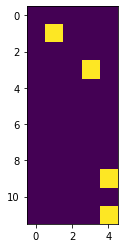

In [21]:
plt.imshow(x>0.95
          )